## Import libs needed:

In [1]:
import os
#for exploratory analysis
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
    
import seaborn as sns
import plotly.express as px

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

#evaluation tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score
import joblib
from time import time


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Reading Data:

In [2]:
original_data = pd.read_csv('./data/titanic.csv')
data = original_data.copy()
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# EDA:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


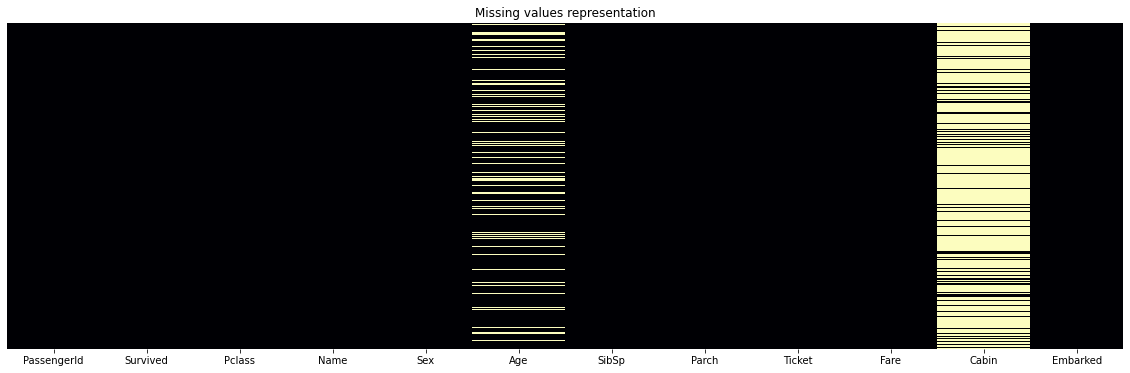

In [4]:
plt.figure(figsize=(20, 6))
sns.heatmap(data.isnull(),
            yticklabels=False,
            cmap='magma',
            cbar=False)
plt.title('Missing values representation')
plt.show()

In [5]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Handling missing values:

In [6]:
data['Age'].fillna(data['Age'].mean(), inplace=True)
data[:3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
cabin = data.groupby(data['Cabin'].isna())['Survived'].count()/data['Survived'].count()
cabin

Cabin
False    0.228956
True     0.771044
Name: Survived, dtype: float64

In [8]:
data['Cabin'] = np.where(data['Cabin'].isna(), 0, 1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S


## Plotting data:

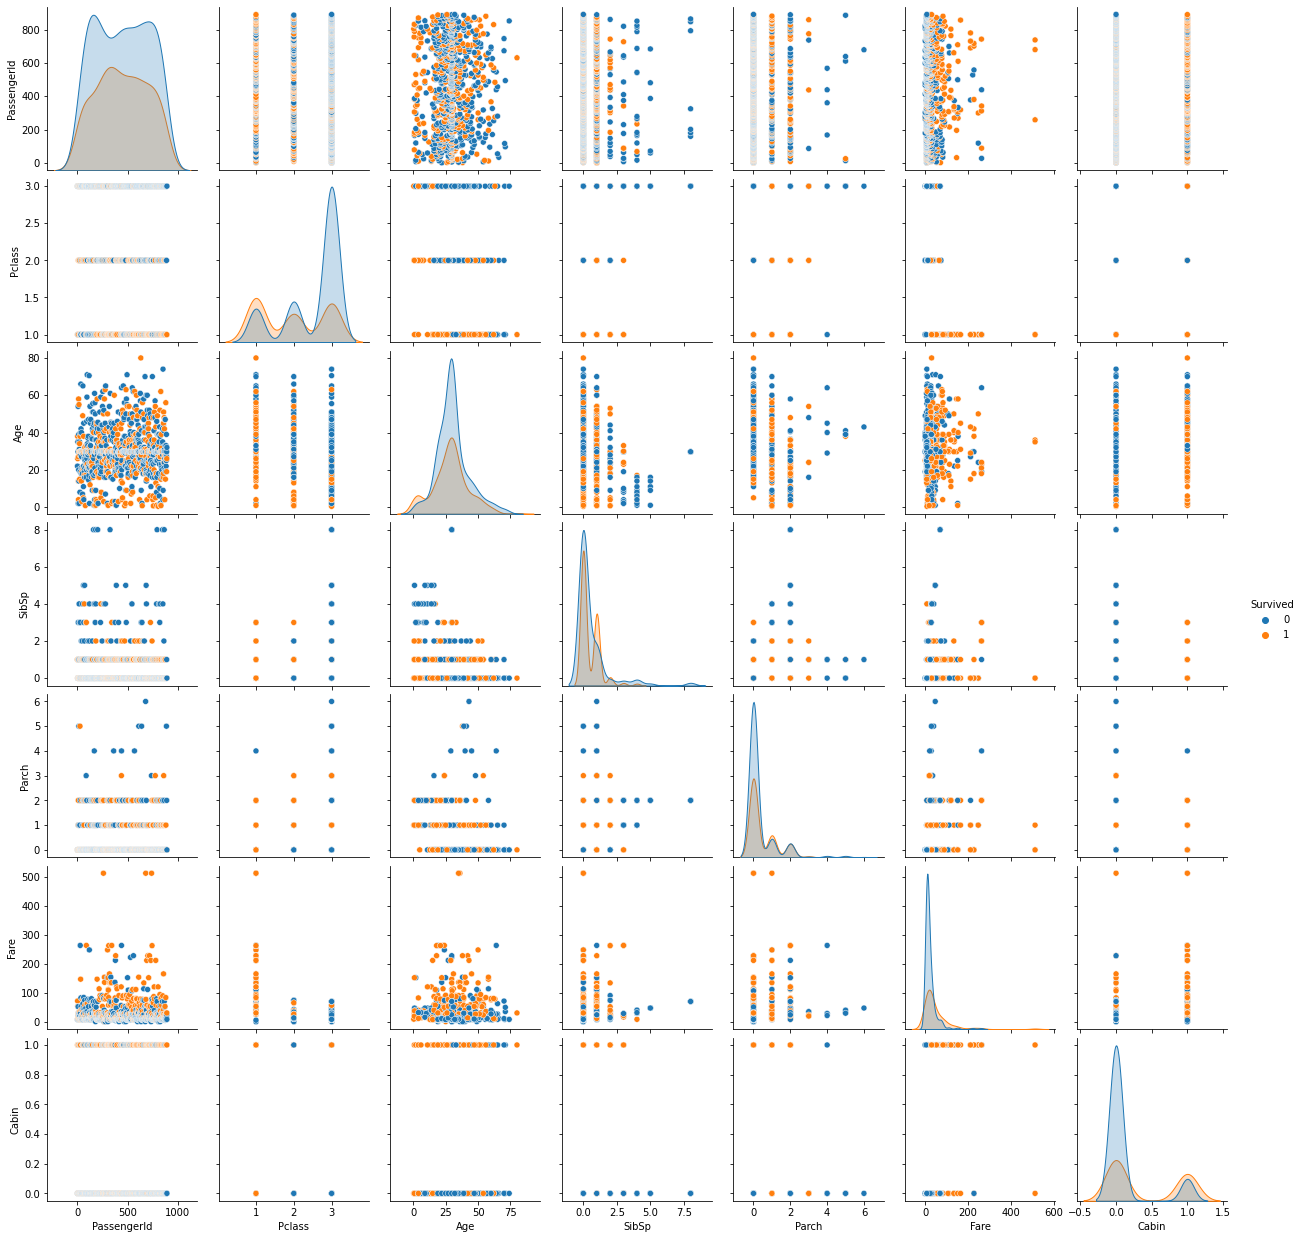

In [9]:
sns.pairplot(data, hue='Survived')

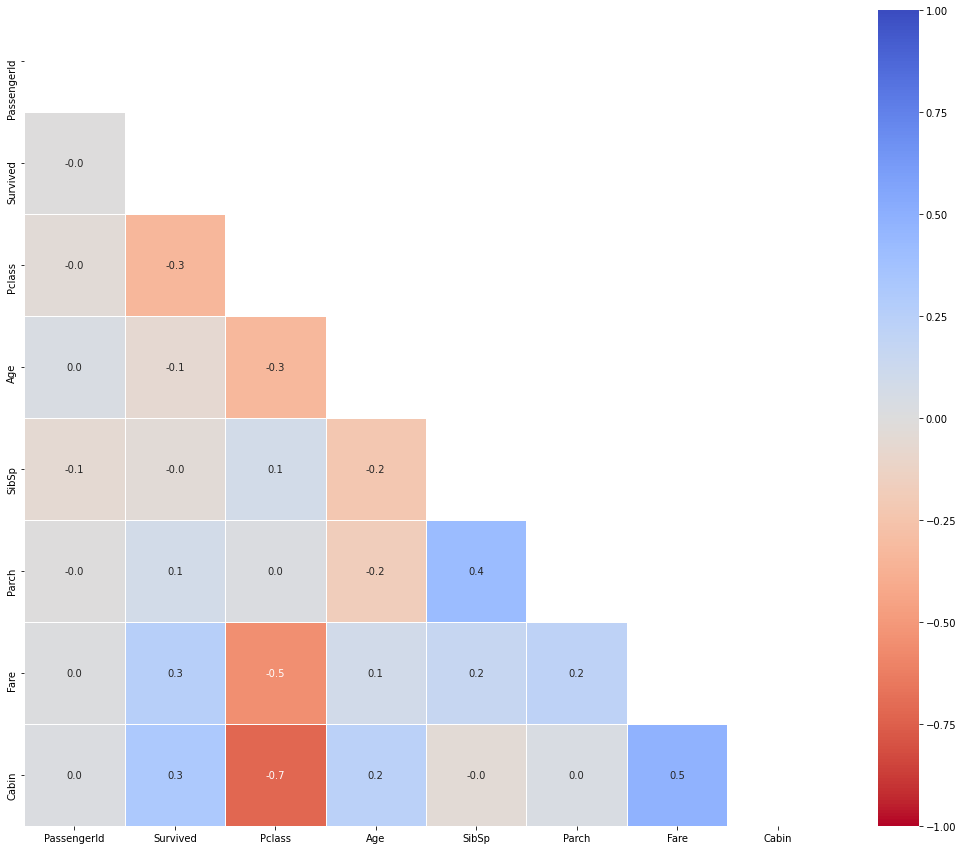

In [10]:
corr = data.corr()
mask = np.triu(corr.corr())
plt.figure(figsize=(18, 15))
sns.heatmap(corr,
            annot=True,
            fmt='.1f',
            cmap='coolwarm_r',
            mask=mask,
            linewidths=1,
            vmin=-1,
            vmax=1)

plt.show()


### Exploring categorical data:

In [11]:
categoricals = data[['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']]


def plot_frequency(cat):
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for ax, cat in zip(axes, categoricals):
        plot = categoricals[cat]
        total = len(categoricals[cat])
        
        sns.countplot(plot, palette='pastel', ax=ax)


        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2.,
                    height + 10,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha="center")

        plt.ylabel('Count')

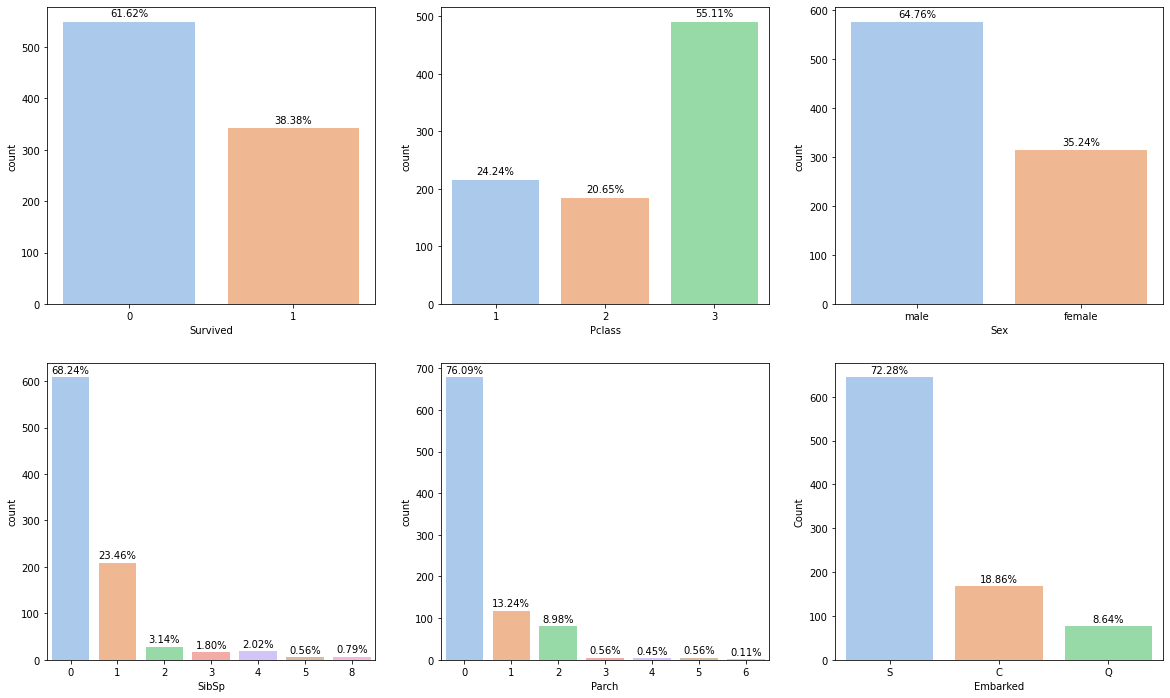

In [12]:
plot_frequency(categoricals)

In [13]:

def plot_survival(categoricals, data):
        
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for ax, cat in zip(axes, categoricals):
        plot = categoricals[cat]
        total = categoricals.groupby
        
        if cat == 'Survived':
            sns.countplot(data[cat], 
            palette='pastel', 
            ax=ax)
        else:
            sns.countplot(plot,
                          data=data,
                          hue='Survived',
                          palette='pastel',
                          ax=ax)
            ax.legend(title='Survived:',
                      loc='upper right',
                      labels=['No', 'Yes'])
        plt.ylabel('Count')

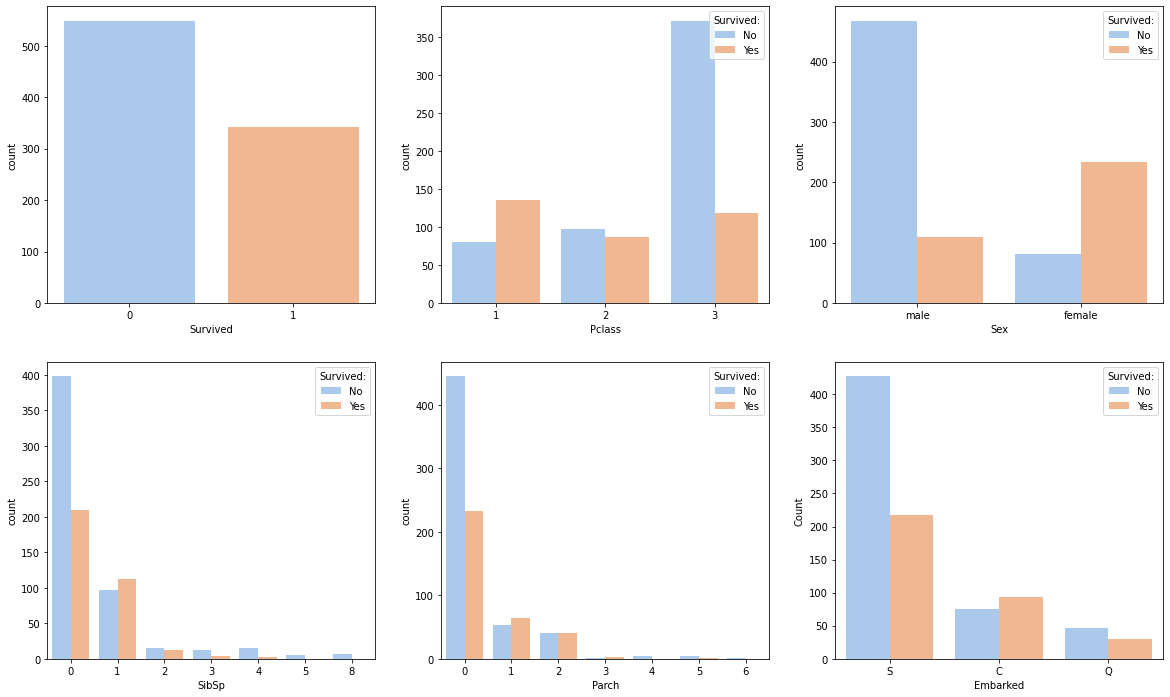

In [14]:
plot_survival(categoricals, data)

### Exploring numerical data:

In [15]:
def plot_numericals(df, feature):
        
    fig = plt.figure(constrained_layout=True, figsize=(12, 8))
    grid = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)
    
    #histogram:
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(data.loc[:, feature],
                 hist=True,
                 kde=True,
                 norm_hist=False,
                 ax=ax1,
                 color='#e74c3c')
    ax1.legend(labels=['Normal', 'Actual'])
                                                     


    #QQ_plot:
    ax2 = fig.add_subplot(grid[1, :2])
    ax2.set_title('Probability Plot')
    stats.probplot(data.loc[:, feature],
                   plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('#e74c3c')
    ax2.get_lines()[0].set_markersize(12.0)

    #boxPlot:    
    ax3 = fig.add_subplot(grid[:, 2])   
    ax3.set_title('Box Plot')
    sns.boxplot(data.loc[:, feature], 
                orient='v', 
                ax=ax3, 
                color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=24))

    plt.suptitle(f'{feature}', fontsize=24)

e:\my_env\ds_env\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
e:\my_env\ds_env\lib\site-packages\seaborn\_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


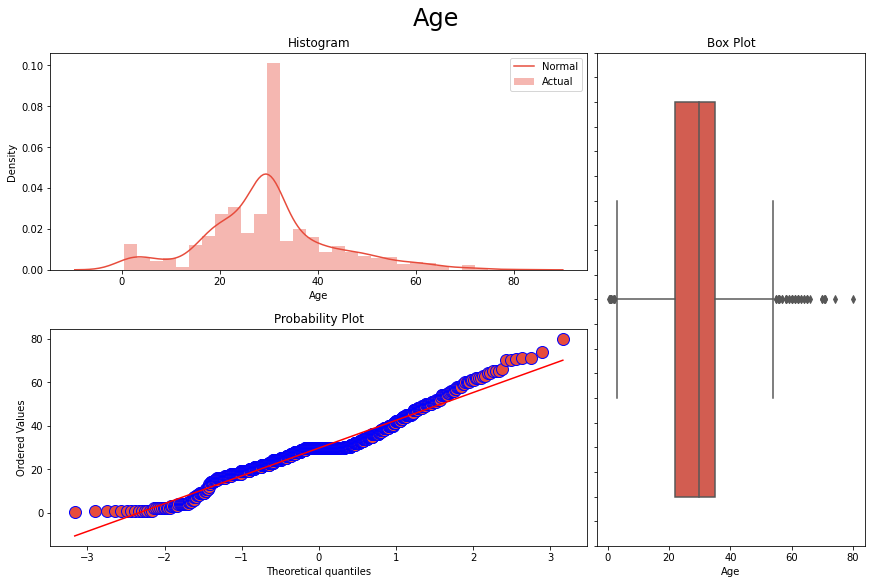

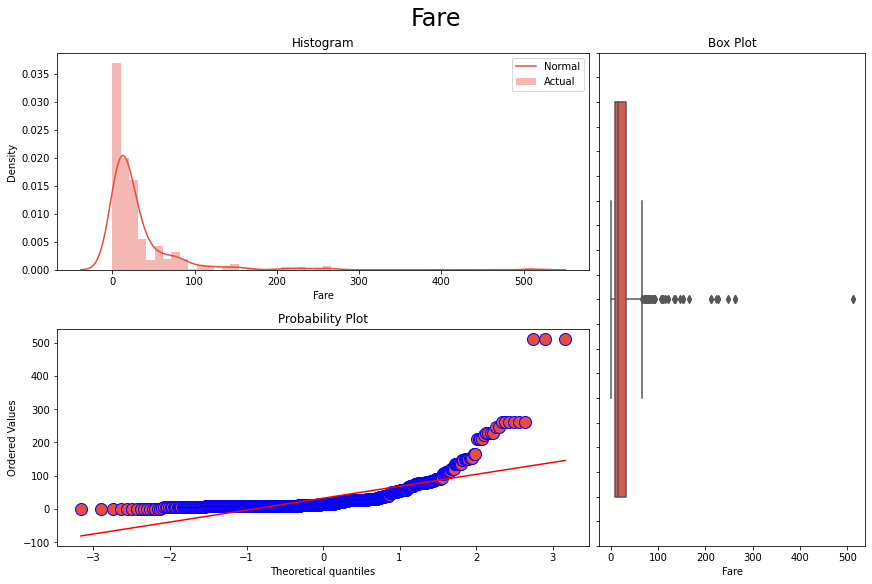

In [16]:
plot_numericals(data,'Age')
plot_numericals(data,'Fare')

In [17]:
data.groupby('Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [18]:
fare_buckets = pd.cut(data['Fare'], right=True, bins=[0,10,20,30,40,50,60,70,80,90,100,600])
n_data = data[['Pclass','Survived']].copy()
fare = n_data.assign(fare_buckets=fare_buckets)
#for better viz:
fare['Survived'] = fare['Survived'].map({0:'died', 1:'survived'})
display(fare)

,Pclass,Survived,fare_buckets
0,3,died,"(0, 10]"
1,1,survived,"(70, 80]"
2,3,survived,"(0, 10]"
3,1,survived,"(50, 60]"
4,3,died,"(0, 10]"
...,...,...,...
886,2,died,"(10, 20]"
887,1,survived,"(20, 30]"
888,3,died,"(20, 30]"
889,1,survived,"(20, 30]"


In [19]:
#survivors per class and fare bucket:

pivot_t= pd.pivot_table(fare, index=['fare_buckets'], columns=['Pclass','Survived'], aggfunc=len, fill_value=0)
pivot_t.style.background_gradient(axis=1)

In [20]:
#spot the death pattern per fare bucket:

pd.crosstab(fare['fare_buckets'], fare['Survived']).style.background_gradient(axis=1, cmap='YlOrRd')

Survived,died,survived
fare_buckets,,
"(0, 10]",255,66
"(10, 20]",103,76
"(20, 30]",79,63
"(30, 40]",35,23
"(40, 50]",12,4
"(50, 60]",11,27
"(60, 70]",11,6
"(70, 80]",12,19
"(80, 90]",3,14


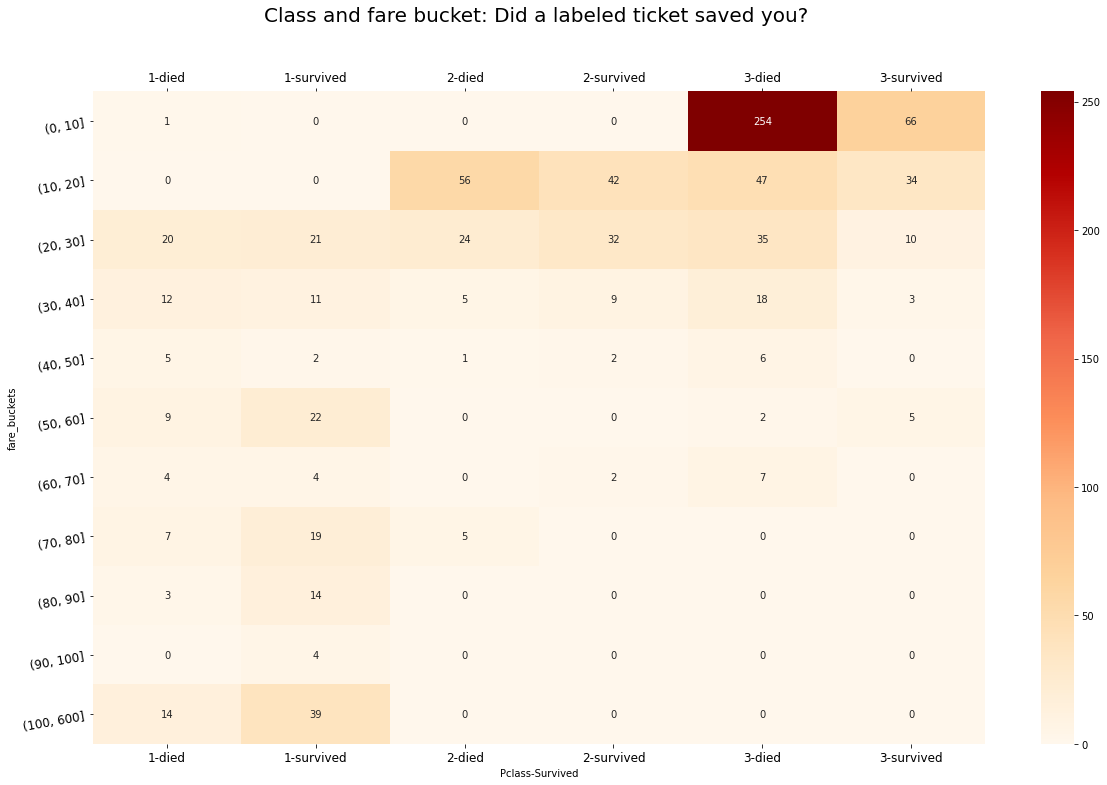

In [21]:
def heatmap():
    plt.figure(figsize=(20,12))
    sns.heatmap(pivot_t, annot=True, cmap='OrRd', fmt='g')
    plt.title('Class and fare bucket: Did a labeled ticket saved you? \n\n', fontsize=20)
    plt.xticks(rotation=0)
    plt.yticks(rotation=10)
    plt.tick_params(axis='both', which='major', labelsize=12, labelbottom = True, bottom=True, top = True, labeltop=True)
    plt.show()

heatmap()

<Figure size 432x288 with 0 Axes>

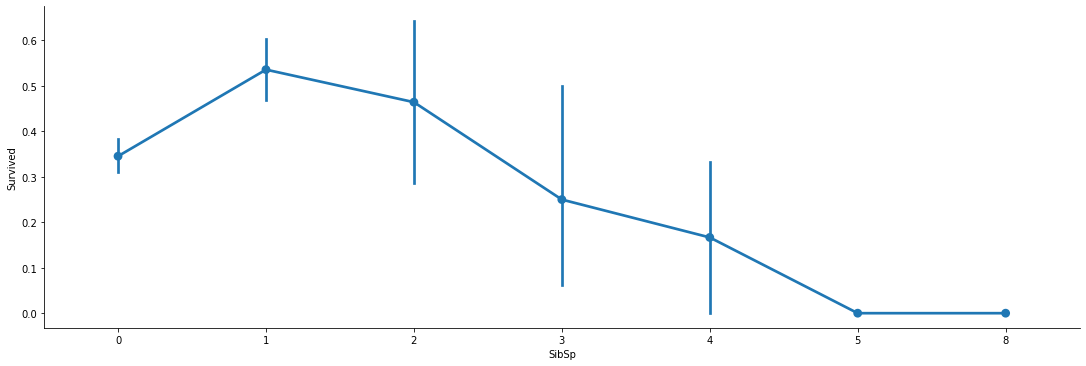

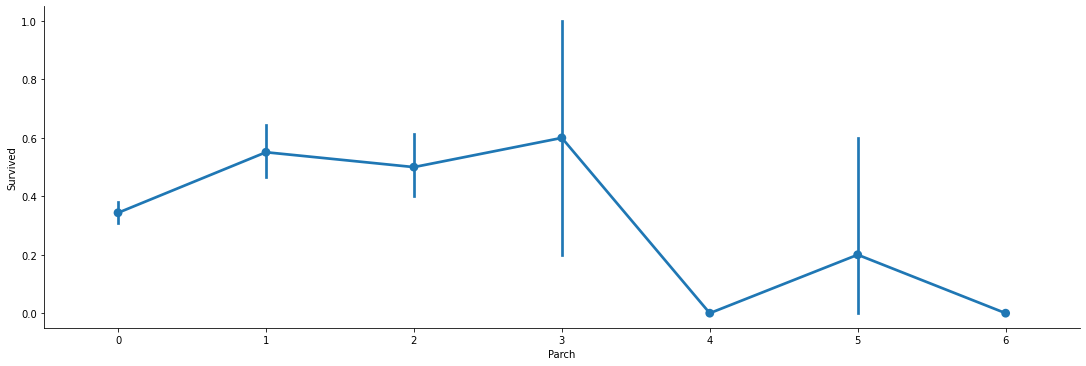

In [22]:
for i, col in enumerate(['SibSp', 'Parch']):
    plt.figure(i)
    sns.catplot(x=col, y='Survived', data=data, kind='point', aspect=3)

### Merging 'SibSp' & 'Parch' into 'Family' col:

In [23]:
data['Family_size'] = data['SibSp'] + data['Parch']
data[:5]     

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family_size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0


### Drop merged cols:

In [24]:
data.drop(['PassengerId', 'SibSp', 'Parch'], axis=1, inplace=True)
data_backup_1 = data.copy()
data[:3]

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_size
0,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,0,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,1,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,0,S,0


### Dummifing the 'Sex' col:

In [25]:
sex_type = {'male': 1, 'female': 0}
data['Sex'] = data['Sex'].map(sex_type)
data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_size
0,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,0,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,1,C,1
2,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,0,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,1,S,1
4,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,0,S,0


### Exploring cabin col:

### Drop unneeded cols & write out a cleaned version:

In [26]:
data.drop(['Name', 'Ticket', 'Embarked'], axis=1, inplace=True)
data[:3]

,Survived,Pclass,Sex,Age,Fare,Cabin,Family_size
0,0,3,1,22.0,7.2500,0,1
1,1,1,0,38.0,71.2833,1,1
2,1,3,0,26.0,7.9250,0,0


In [27]:
data_backup_2 = data.copy()
data.to_csv('./data/cleaned_titanic.csv', index=False)

## Splitting data for training:

In [28]:
features = data.drop(['Survived'], axis=1)
label = data.Survived

In [29]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=.5, random_state=42)

In [30]:
for i in [y_train, y_val, y_test]:
    print(round(len(i)/len(label), 1))

0.6
0.2
0.2


## Write out training sub-datasets

In [31]:
X_train.to_csv('./data/split_X_train.csv', index=False)
X_val.to_csv('./data/split_X_val.csv', index=False)
X_test.to_csv('./data/split_X_test.csv', index=False)

y_train.to_csv('./data/split_y_train.csv', index=False)
y_val.to_csv('./data/split_y_val.csv', index=False)
y_test.to_csv('./data/split_y_test.csv', index=False)

# Training models

## Class: 

In [32]:
def print_results(model, name):
    print('BEST PARAMS: {}\n'.format(model.best_params_))

    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
        
    joblib.dump(model.best_estimator_, './data/{}.pkl'.format(name))

## *LogisticReg*:

In [33]:
lr = LogisticRegression()
parameters = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

model_LR = GridSearchCV(lr, parameters, cv=5)
model_LR.fit(X_train, y_train)

print_results(model_LR, 'model_LR')

BEST PARAMS: {'C': 1}

0.67 (+/-0.077) for {'C': 0.001}
0.708 (+/-0.098) for {'C': 0.01}
0.777 (+/-0.134) for {'C': 0.1}
0.8 (+/-0.118) for {'C': 1}
0.794 (+/-0.116) for {'C': 10}
0.794 (+/-0.116) for {'C': 100}
0.794 (+/-0.116) for {'C': 1000}


## *SupportVectorMachine*:


In [34]:
svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}

model_SVC = GridSearchCV(svc, parameters, cv=5)
model_SVC.fit(X_train, y_train)

print_results(model_SVC, 'model_SVC')

BEST PARAMS: {'C': 0.1, 'kernel': 'linear'}

0.796 (+/-0.115) for {'C': 0.1, 'kernel': 'linear'}
0.654 (+/-0.06) for {'C': 0.1, 'kernel': 'rbf'}
0.796 (+/-0.115) for {'C': 1, 'kernel': 'linear'}
0.661 (+/-0.048) for {'C': 1, 'kernel': 'rbf'}
0.796 (+/-0.115) for {'C': 10, 'kernel': 'linear'}
0.684 (+/-0.07) for {'C': 10, 'kernel': 'rbf'}


## *MultilayerPerceptron*:

In [35]:
mlp = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

model_MLP = GridSearchCV(mlp, parameters, cv=5)
model_MLP.fit(X_train, y_train)

print_results(model_MLP, 'model_MLP')

e:\my_env\ds_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\my_env\ds_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\my_env\ds_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\my_env\ds_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
e:\my_env\ds_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarn

BEST PARAMS: {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}

0.73 (+/-0.083) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'constant'}
0.708 (+/-0.085) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'invscaling'}
0.725 (+/-0.068) for {'activation': 'relu', 'hidden_layer_sizes': (10,), 'learning_rate': 'adaptive'}
0.744 (+/-0.137) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'constant'}
0.777 (+/-0.08) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling'}
0.792 (+/-0.092) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}
0.785 (+/-0.11) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
0.789 (+/-0.088) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling'}
0.777 (+/-0.133) for {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning

e:\my_env\ds_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## *RandomForest*:

In [36]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [5, 50, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

model_RF = GridSearchCV(rf, parameters, cv=5)
model_RF.fit(X_train, y_train)

print_results(model_RF, 'model_RF')

BEST PARAMS: {'max_depth': 4, 'n_estimators': 5}

0.796 (+/-0.125) for {'max_depth': 2, 'n_estimators': 5}
0.794 (+/-0.119) for {'max_depth': 2, 'n_estimators': 50}
0.789 (+/-0.128) for {'max_depth': 2, 'n_estimators': 250}
0.828 (+/-0.135) for {'max_depth': 4, 'n_estimators': 5}
0.824 (+/-0.113) for {'max_depth': 4, 'n_estimators': 50}
0.826 (+/-0.104) for {'max_depth': 4, 'n_estimators': 250}
0.811 (+/-0.077) for {'max_depth': 8, 'n_estimators': 5}
0.815 (+/-0.077) for {'max_depth': 8, 'n_estimators': 50}
0.815 (+/-0.075) for {'max_depth': 8, 'n_estimators': 250}
0.788 (+/-0.094) for {'max_depth': 16, 'n_estimators': 5}
0.809 (+/-0.038) for {'max_depth': 16, 'n_estimators': 50}
0.811 (+/-0.025) for {'max_depth': 16, 'n_estimators': 250}
0.794 (+/-0.062) for {'max_depth': 32, 'n_estimators': 5}
0.815 (+/-0.028) for {'max_depth': 32, 'n_estimators': 50}
0.809 (+/-0.027) for {'max_depth': 32, 'n_estimators': 250}
0.783 (+/-0.06) for {'max_depth': None, 'n_estimators': 5}
0.794 (+/-0.03)

## *GradiantBoosting*:

In [37]:
gb = GradientBoostingClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}

model_GB = GridSearchCV(gb, parameters, cv=5)
model_GB.fit(X_train, y_train)

print_results(model_GB, 'model_GB')

BEST PARAMS: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}

0.624 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 5}
0.796 (+/-0.115) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.796 (+/-0.115) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 250}
0.811 (+/-0.117) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 500}
0.624 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 5}
0.811 (+/-0.069) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.83 (+/-0.074) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 250}
0.841 (+/-0.077) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
0.624 (+/-0.007) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 5}
0.822 (+/-0.052) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
0.818 (+/-0.043) for {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 250}
0.822 (+/-0.037) for {'learning_r

## *DecisionTree*:

In [38]:
dt = DecisionTreeClassifier()
parameters= {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 9, 10, 100],
    'max_features': [None, 5],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [2,5,10]

}

model_DT = GridSearchCV(dt, parameters, cv=5)
model_DT.fit(X_train, y_train)

print_results(model_DT, 'model_DT')

BEST PARAMS: {'criterion': 'entropy', 'max_depth': 9, 'max_features': 5, 'min_samples_leaf': 10, 'min_samples_split': 5}

0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
0.796 (+/-0.115) for {'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'min_samples_leaf': 10, 'mi

# Evaluating the models and electing the best performer: 

In [39]:
models = {}

for mdl in os.listdir('./data'):
    if mdl.endswith('.pkl'):
        md = mdl[6:-4]
        models[md] = joblib.load('./data/{}'.format(mdl))
models

{'DT': DecisionTreeClassifier(max_depth=7, min_samples_leaf=10, min_samples_split=10),
 'GB': GradientBoostingClassifier(learning_rate=0.01, n_estimators=500),
 'LR': LogisticRegression(C=1),
 'MLP': MLPClassifier(activation='tanh', learning_rate='invscaling'),
 'RF': RandomForestClassifier(max_depth=4, n_estimators=50),
 'SVC': SVC(C=0.1, kernel='linear')}

In [40]:
def evaluate_model(name, model, X_val, y_val):
    start = time()
    pred = model.predict(X_val)
    end = time()
    accuracy = round(accuracy_score(y_val, pred), 3)
    precision = round(precision_score(y_val, pred), 3)
    recall = round(recall_score(y_val, pred), 3)
    print('{} -- Accuracy: {} / Precision: {} / Recall: {} / Latency: {}ms'.format(name,
                                                                                   accuracy,
                                                                                   precision,
                                                                                   recall,
                                                                                   round((end - start)*1000, 1)))

In [41]:
for name, mdl in models.items():    
    evaluate_model(name, mdl, X_val, y_val)

DT -- Accuracy: 0.781 / Precision: 0.75 / Recall: 0.6 / Latency: 3.0ms
GB -- Accuracy: 0.815 / Precision: 0.808 / Recall: 0.646 / Latency: 4.0ms
LR -- Accuracy: 0.775 / Precision: 0.712 / Recall: 0.646 / Latency: 1.0ms
MLP -- Accuracy: 0.77 / Precision: 0.7 / Recall: 0.646 / Latency: 3.0ms
RF -- Accuracy: 0.809 / Precision: 0.83 / Recall: 0.6 / Latency: 8.0ms
SVC -- Accuracy: 0.747 / Precision: 0.672 / Recall: 0.6 / Latency: 4.0ms


In [42]:
def evaluate_model(X_val, y_val):

    row_idx = 0
    table = pd.DataFrame()
    
    for label, model in  models.items():
        start = time()
        pred = model.predict(X_val)
        end = time()
        accuracy = round(accuracy_score(y_val, pred), 3)
        precision = round(precision_score(y_val, pred), 3)
        recall = round(recall_score(y_val, pred), 3)

        table.loc[row_idx, 'Model'] = label
        table.loc[row_idx, 'Accuracy'] = accuracy
        table.loc[row_idx, 'Precision'] = precision
        table.loc[row_idx, 'Recall'] = recall
        table.loc[row_idx, 'Latency'] = round((end - start)*1000, 1)

        table.sort_values(by=['Accuracy'], ascending=False, inplace=True)
        row_idx +=1
    
    return table

In [43]:
evalu_table = evaluate_model(X_val, y_val)
evalu_table.style.background_gradient(cmap='summer')

,Model,Accuracy,Precision,Recall,Latency
1,GB,0.815000,0.808000,0.646000,4.000000
4,RF,0.809000,0.830000,0.600000,9.000000
0,DT,0.781000,0.750000,0.600000,2.000000
2,LR,0.775000,0.712000,0.646000,2.000000
3,MLP,0.770000,0.700000,0.646000,3.000000
5,SVC,0.747000,0.672000,0.600000,3.000000
